In [1]:
import nltk
import pandas as pd
import numpy as np

In [2]:
hotstar = pd.read_csv('hotstar.allreviews_sentiments.csv')

In [3]:
hotstar.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [4]:
print(hotstar.shape)

(5053, 13)


In [5]:
hotstar['Reviews'].head()

0                                                   Hh
1                                                   No
2    @hotstar_helps during paymnt for premium subsc...
3    @hotstartweets I am currently on Jio network a...
4    @hotstartweets the episodes of Sarabhai vs Sar...
Name: Reviews, dtype: object

## GETTING SENTIMENTAL SCORE

In [6]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASHISH\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti = SentimentIntensityAnalyzer()
print(senti.polarity_scores('i love india'))
print(senti.polarity_scores('i LOVE india'))
print(senti.polarity_scores('i love india :)'))

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
{'neg': 0.0, 'neu': 0.169, 'pos': 0.831, 'compound': 0.7125}
{'neg': 0.0, 'neu': 0.122, 'pos': 0.878, 'compound': 0.802}


C:\Users\ASHISH\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [8]:
print(senti.polarity_scores('i love india')['compound'])

0.6369


Neutral     2149
Positive    2137
Negative     767
Name: sentiment_vader, dtype: int64

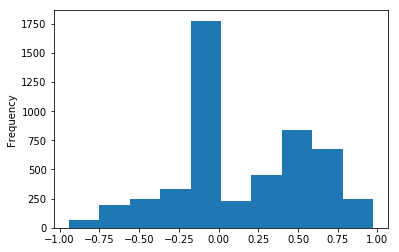

In [18]:
%matplotlib inline
def get_sentiment_score(review):
    compound_score = senti.polarity_scores(review)['compound']
    return compound_score

def get_sentiment(score):
    if score > 0.25:
        return 'Positive'
    elif score < -0.25:
        return 'Negative'
    else:
        return 'Neutral'

hotstar['sentiment_score'] = hotstar['Reviews'].apply(get_sentiment_score)
hotstar['sentiment_vader'] = hotstar['sentiment_score'].apply(get_sentiment)
hotstar['sentiment_score'].plot.hist()
hotstar['sentiment_vader'].value_counts()

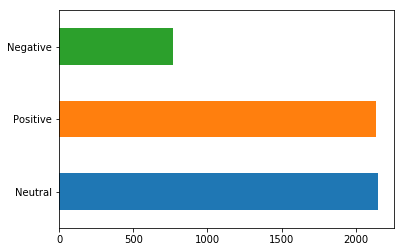

In [20]:
hotstar['sentiment_vader'].value_counts().plot.barh()

## TRENDING ON SENTIMENTAL ANALYSIS

#### DATE-TIME

In [22]:
hotstar['date'] = pd.to_datetime(hotstar['Created_Date'])
hotstar['date'].min(),hotstar['date'].max()

(Timestamp('2017-08-04 00:00:00'), Timestamp('2017-08-13 00:00:00'))

In [23]:
hotstar.groupby(['date','sentiment_vader']).size()

date        sentiment_vader
2017-08-04  Negative            85
            Neutral            130
            Positive           112
2017-08-05  Negative           111
            Neutral            177
            Positive           108
2017-08-06  Negative            50
            Neutral            144
            Positive            93
2017-08-07  Negative            72
            Neutral            204
            Positive           121
2017-08-08  Negative            26
            Neutral            118
            Positive            77
2017-08-09  Negative            86
            Neutral            254
            Positive           302
2017-08-10  Negative           143
            Neutral            401
            Positive           485
2017-08-11  Negative           116
            Neutral            404
            Positive           536
2017-08-12  Negative            69
            Neutral            252
            Positive           247
2017-08-13  Negative       

In [28]:
sent_trend = hotstar.groupby(['date','sentiment_vader']).size()
sent_trend = sent_trend.reset_index()
sent_trend = sent_trend.rename(columns = {0:'count'})
sent_trend.head()

,date,sentiment_vader,count
0,2017-08-04,Negative,85
1,2017-08-04,Neutral,130
2,2017-08-04,Positive,112
3,2017-08-05,Negative,111
4,2017-08-05,Neutral,177


In [30]:
pos_rows = sent_trend[sent_trend['sentiment_vader'] == 'Positive']
neg_rows = sent_trend[sent_trend['sentiment_vader'] == 'Negative']
neu_rows = sent_trend[sent_trend['sentiment_vader'] == 'Neutral']

Text(0.5,1,'Sentiment Analysis on Hotstar Reviews')

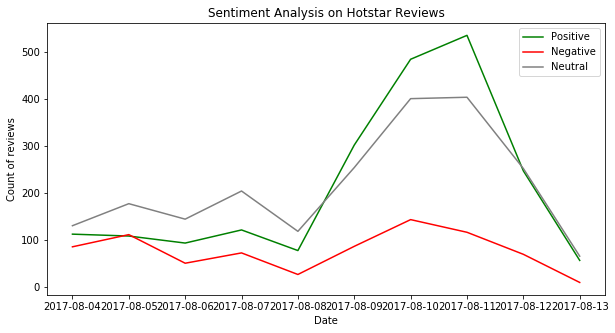

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

plt.plot(pos_rows['date'],pos_rows['count'],color = 'green')
plt.plot(neg_rows['date'],neg_rows['count'],color = 'red')
plt.plot(neu_rows['date'],neu_rows['count'],color = 'grey')

plt.legend(['Positive','Negative','Neutral'])
plt.xlabel('Date')
plt.ylabel('Count of reviews')
plt.title('Sentiment Analysis on Hotstar Reviews')

According to the user reviews HOTSTAR is good

In [49]:
accuracy_score(hotstar['Sentiment_Manual'],hotstar['sentiment_vader'])

0.5513556303186226

# SUPERVISED SENTIMENT ANALYSIS

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score,roc_curve,auc,confusion_matrix,classification_report

stop_words = nltk.corpus.stopwords.words('english')
stop_words = list(np.setdiff1d(stop_words,['not']))
junk_words = []

stop_words.extend(junk_words)
stemmer = nltk.PorterStemmer()

docs = hotstar['Reviews'].fillna('').str.lower().str.replace('[^a-z ]', '')
docs_clean = docs.apply(lambda v : ' '.join([stemmer.stem(word) for word in v.split(' ') \
                                            if word not in stop_words]))

train,test= train_test_split(docs_clean,test_size = 0.3,random_state = 100)

cv = CountVectorizer()
cv.fit(train)

train_x = cv.transform(train)
test_x = cv.transform(test)

train_y = hotstar.loc[train.index]['Sentiment_Manual']
test_y = hotstar.loc[test.index]['Sentiment_Manual']

randomforest_model = RandomForestClassifier(n_estimators = 300,random_state = 100)   #using randomforestclassifier
randomforest_model.fit(train_x,train_y)
pred_class = randomforest_model.predict(test_x)
accuracy_score(test_y,pred_class)

0.7486807387862797

In [46]:
adaboost_model = AdaBoostClassifier(n_estimators = 300,random_state = 100)    #using adaboostclassifier
adaboost_model.fit(train_x,train_y)
pred_class = adaboost_model.predict(test_x)
accuracy_score(test_y,pred_class)

0.6893139841688655

In [47]:
x = ['a','b','c']
list(np.setdiff1d(x,['c']))
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASHISH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### NOTE :- Supervised way always gives better results than Unsupervised way

## WEB SCRAPING


In [50]:
import os
os.getcwd()

'C:\\Users\\ASHISH\\Desktop\\TEXT MINING and SENTIMENT ANALYSIS'

In [51]:
!pip install selenium  #selenium package install

In [104]:
from selenium import webdriver
browser = webdriver.Chrome('chromedriver.exe')    #run automatically with python

In [56]:
url =  'https://bit.ly/2QjOT2Z'
browser.get(url)

In [58]:
parent_tags = browser.find_elements_by_css_selector('li.job-listing')
len(parent_tags)

25

In [61]:
#for job roles
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    print(title)

Data Science Architect
Data Science Specialist
Data Science Intern
Data Science for Banking
Head - Data Science and Analytics
Data Science Expert-NLP
Data Science Associate
Data Science Manager
Global Operations Data Science Consultant
Data Scientist
Product Manager (Data Science)
Manager, Research Data Science
AI Engineering Intern with Data Science and Insights
Data Science Associate (Bengaluru, India)
Data Science modelers
Data Scientist
Data Science Associate Manager
Fresher Opportunities - Java/Scala/Data Science/Golang
Data Science (Jupyter/Azure ML/MatLab)
Data Scientist/Data Analytics
Data Science Expert-Computer Vision
Data Science Consultant (Bengaluru, India)
Data Science - Cocoa And Chocolate
KGS | Management Consulting | Analytics | Data Science
Data Science Associate Consultant (New Delhi, India)


In [62]:
#job roles with companies
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    print(title,'|',company)

Data Science Architect | YASH Technologies
Data Science Specialist | Accenture in India
Data Science Intern | Swiggy
Data Science for Banking | Accenture in India
Head - Data Science and Analytics | Biz2Credit
Data Science Expert-NLP | Talentica Software
Data Science Associate | Indus Insights
Data Science Manager | Indus Insights
Global Operations Data Science Consultant | Hewlett Packard Enterprise
Data Scientist | Arnold Consulting Private Limited
Product Manager (Data Science) | People Interactive
Manager, Research Data Science | Amazon
AI Engineering Intern with Data Science and Insights | Genpact
Data Science Associate (Bengaluru, India) | ZS
Data Science modelers | Infosys
Data Scientist | Elucidata 
Data Science Associate Manager | Accenture in India
Fresher Opportunities - Java/Scala/Data Science/Golang | Obsessory
Data Science (Jupyter/Azure ML/MatLab) | Accenture in India
Data Scientist/Data Analytics | Live Connections
Data Science Expert-Computer Vision | Talentica Softwar

In [69]:
#for job title with company and location
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    
    
    
    location_tag = job.find_element_by_css_selector('span.job-location')
    location_tag = location_tag.find_element_by_css_selector('span')
    location = location_tag.get_attribute('innerHTML')
    
    print(title,'|',company,'|',location)

Data Science Architect | YASH Technologies | Plot No. 23/1, IT &amp; ITES MIDC, , Phase-3, Hinjawadi, Pune, MH 411057, IN
Data Science Specialist | Accenture in India | Bangalore, IN
Data Science Intern | Swiggy | Bengaluru, Karnataka, India
Data Science for Banking | Accenture in India | Mumbai, IN
Head - Data Science and Analytics | Biz2Credit | Noida, Uttar Pradesh, India
Data Science Expert-NLP | Talentica Software | Pune, Maharashtra, India
Data Science Associate | Indus Insights | 805 Tower A Spaze TechPark Sohna Road, Gurgaon, HR 122002, IN
Data Science Manager | Indus Insights | 805 Tower A Spaze TechPark Sohna Road, Gurgaon, HR 122002, IN
Global Operations Data Science Consultant | Hewlett Packard Enterprise | Bangalore, IN
Data Scientist | Arnold Consulting Private Limited | Bengaluru Area, India
Product Manager (Data Science) | People Interactive | Ground Floor, Film Centre Bldg Tardeo Road, Mumbai, MH 400034, IN
Manager, Research Data Science | Amazon | Bangalore, IN
AI Eng

In [80]:
#for job title with company and location
import bs4
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    
    
    
    location_tag = job.find_element_by_css_selector('span.job-location')
    location_tag = location_tag.find_element_by_css_selector('span')
    location = location_tag.get_attribute('innerHTML')
    
    description_tag = job.find_element_by_css_selector('div.job-description')
    description = description_tag.get_attribute('innerHTML')
    description = bs4.BeautifulSoup(description,'html.parser').text
    #rep_str = '...<span class = "job-attribution"> </span>'
    description = description.replace(rep_str,'')
    
    print(description)
    print('------------')
    

YASH Technologies, a leading enterprise business and technology solution partner for medium and large global customers, is seeking Data Science Architect Professionals, who ... 
------------
We are looking for someone who has a comprehensive skill set: “Hard” skills: Assist in growing data science skills in the team, i.e. organizing learning activities, create ... www.accenture.com
------------
The Data Science team is a team of scientists without white coats, constantly pondering in the realm of data and building AI/ML solutions to make the Swiggy ecosystem intelligent. 
------------
Job Requirements : 1 Responsibilities :A:Manage data science and analytics team to carry out some of the above tasks 2 Professional experience : A:Lead the data science ... www.accenture.com
------------
Must demonstrate Macro and Micro level skills and have both strategic and operational understanding of data science, with solid business instincts and judgement. Experience in ... 
------------
Hands-on e

In [81]:
#for job title - company - location - description
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    
    
    
    location_tag = job.find_element_by_css_selector('span.job-location')
    location_tag = location_tag.find_element_by_css_selector('span')
    location = location_tag.get_attribute('innerHTML')
    
    
    description_tag = job.find_element_by_css_selector('div.job-description')
    description = description_tag.get_attribute('innerHTML')
    description = bs4.BeautifulSoup(description,'html.parser').text
    #rep_str = '...<span class = "job-attribution"> </span>'
    description = description.replace(rep_str,'')

    
    print(title,'|',company,'|',location,'|',description)

Data Science Architect | YASH Technologies | Plot No. 23/1, IT &amp; ITES MIDC, , Phase-3, Hinjawadi, Pune, MH 411057, IN | YASH Technologies, a leading enterprise business and technology solution partner for medium and large global customers, is seeking Data Science Architect Professionals, who ... 
Data Science Specialist | Accenture in India | Bangalore, IN | We are looking for someone who has a comprehensive skill set: “Hard” skills: Assist in growing data science skills in the team, i.e. organizing learning activities, create ... www.accenture.com
Data Science Intern | Swiggy | Bengaluru, Karnataka, India | The Data Science team is a team of scientists without white coats, constantly pondering in the realm of data and building AI/ML solutions to make the Swiggy ecosystem intelligent. 
Data Science for Banking | Accenture in India | Mumbai, IN | Job Requirements : 1 Responsibilities :A:Manage data science and analytics team to carry out some of the above tasks 2 Professional experi

In [96]:
#for job title - company - location - description
jobs = pd.DataFrame()
for job in parent_tags:
    title_tag = job.find_element_by_css_selector('span.job-title-text')
    title = title_tag.get_attribute('innerHTML').replace('<b>','').replace('</b>','')
    
    company_tag = job.find_element_by_css_selector('span.company-name-text')
    company = company_tag.get_attribute('innerHTML')
    
    
    
    location_tag = job.find_element_by_css_selector('span.job-location')
    location_tag = location_tag.find_element_by_css_selector('span')
    location = location_tag.get_attribute('innerHTML')
    
    
    description_tag = job.find_element_by_css_selector('div.job-description')
    description = description_tag.get_attribute('innerHTML')
    description = bs4.BeautifulSoup(description,'html.parser').text   #this line is used to remove tags
    #rep_str = '...<span class = "job-attribution"> </span>'
    #description = description.replace(rep_str,'')

    
    curr_job = {'title':title,
                'company' : company,
                'location' : location,
                'description' : description 
               }
    jobs = jobs.append(curr_job,ignore_index = True)

In [98]:
jobs.head(10)

,company,description,location,title
0,YASH Technologies,"YASH Technologies, a leading enterprise busine...","Plot No. 23/1, IT &amp; ITES MIDC, , Phase-3, ...",Data Science Architect
1,Accenture in India,We are looking for someone who has a comprehen...,"Bangalore, IN",Data Science Specialist
2,Swiggy,The Data Science team is a team of scientists ...,"Bengaluru, Karnataka, India",Data Science Intern
3,Accenture in India,Job Requirements : 1 Responsibilities :A:Manag...,"Mumbai, IN",Data Science for Banking
4,Biz2Credit,Must demonstrate Macro and Micro level skills ...,"Noida, Uttar Pradesh, India",Head - Data Science and Analytics
5,Talentica Software,Hands-on experience with use of standard natur...,"Pune, Maharashtra, India",Data Science Expert-NLP
6,Indus Insights,Indus Insights is looking for top notch talent...,"805 Tower A Spaze TechPark Sohna Road, Gurgaon...",Data Science Associate
7,Indus Insights,Indus Insights is looking for top-notch profes...,"805 Tower A Spaze TechPark Sohna Road, Gurgaon...",Data Science Manager
8,Hewlett Packard Enterprise,"Strong Microsoft Excel, Access and PowerPoint ...","Bangalore, IN",Global Operations Data Science Consultant
9,Arnold Consulting Private Limited,We are looking for outstanding machine learnin...,"Bengaluru Area, India",Data Scientist


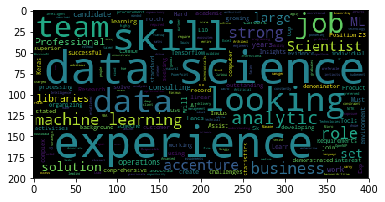

In [99]:
from wordcloud import WordCloud

wc = WordCloud().generate(' '.join(jobs['description']))
plt.imshow(wc)

## Text Summarization

In [100]:
!pip install sumy    #install sumy package

  Running setup.py bdist_wheel for docopt: started
  Running setup.py bdist_wheel for docopt: finished with status 'done'
  Stored in directory: C:\Users\ASHISH\AppData\Local\pip\Cache\wheels\9b\04\dd\7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
  Running setup.py bdist_wheel for breadability: started
  Running setup.py bdist_wheel for breadability: finished with status 'done'
  Stored in directory: C:\Users\ASHISH\AppData\Local\pip\Cache\wheels\5a\4d\a1\510b12c5e65e0b2b3ce539b2af66da0fc57571e528924f4a52
Successfully built docopt breadability


In [102]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

In [106]:
from selenium import webdriver
browser = webdriver.Chrome('chromedriver.exe')    

In [107]:
url = 'https://www.livemint.com/Companies/b4LtGm53W966uRNUiVQQKL/Maggi-case-Supreme-Court-revives-classaction-suit-against.html?utm_campaign=fullarticle&utm_medium=referral&utm_source=inshorts'
browser.get(url)

In [110]:
div_tag = browser.find_element_by_css_selector('div.content')
para_tags = div_tag.find_elements_by_css_selector('p')
len(para_tags)

12

In [115]:
sentences = ''
for para in para_tags:
    para_text = para.get_attribute('innerHTML')
    sentences = sentences + ' ' + para_text
    

sentences

' <b>New Delhi:</b> In a setback to Nestle India Ltd, the Supreme Court on Thursday lifted a stay on the proceedings of a class-action suit filed by the central government against the maker of Maggi noodles in the apex consumer court. The National Consumer Disputes Redressal Commission (NCDRC) can now continue proceedings against Nestle India, based on  the results of tests of Maggi noodle samples conducted by the Central Food Technological Research Institute (CFTRI) in Mysuru. In December 2015, the top court had stayed NCDRC proceedings against Nestle India and directed the testing of the noodles by CFTRI. In April next year, Nestle cleared all tests and Maggi was declared safe for consumption. The government had approached the consumer court alleging unfair trade practices, false labelling and misleading advertisements by Nestle and sought a compensation of ₹640 crore under the provisions of the Consumer Protection Act, 1986.  The apex court’s ruling on Thursday means that Nestle may

In [116]:
sentences = ''
for para in para_tags:
    para_text = para.get_attribute('innerHTML')
    sentences = sentences + ' ' + para_text
    sentences = bs4.BeautifulSoup(sentences,'html.parser').text   #this line is used to remove html tags
    
sentences

' New Delhi: In a setback to Nestle India Ltd, the Supreme Court on Thursday lifted a stay on the proceedings of a class-action suit filed by the central government against the maker of Maggi noodles in the apex consumer court. The National Consumer Disputes Redressal Commission (NCDRC) can now continue proceedings against Nestle India, based on  the results of tests of Maggi noodle samples conducted by the Central Food Technological Research Institute (CFTRI) in Mysuru. In December 2015, the top court had stayed NCDRC proceedings against Nestle India and directed the testing of the noodles by CFTRI. In April next year, Nestle cleared all tests and Maggi was declared safe for consumption. The government had approached the consumer court alleging unfair trade practices, false labelling and misleading advertisements by Nestle and sought a compensation of ₹640 crore under the provisions of the Consumer Protection Act, 1986.  The apex court’s ruling on Thursday means that Nestle may have t

In [117]:
sentences = ''
for para in para_tags:
    para_text = para.get_attribute('innerHTML')
    sentences = sentences + ' ' + para_text
    sentences = bs4.BeautifulSoup(sentences,'html.parser').text   #this line is used to remove html tags
    
sentences[:10]   #this line is to get 1st 10 words of the para

' New Delhi'

In [118]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASHISH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [120]:
#for important sentences in news
parser = PlaintextParser(sentences,Tokenizer('english'))

summarizer = LexRankSummarizer()
summarized_sentences = summarizer(parser.document,10)

for sentence in summarized_sentences:
    print(sentence)
    print('--------------')

New Delhi: In a setback to Nestle India Ltd, the Supreme Court on Thursday lifted a stay on the proceedings of a class-action suit filed by the central government against the maker of Maggi noodles in the apex consumer court.
--------------
The National Consumer Disputes Redressal Commission (NCDRC) can now continue proceedings against Nestle India, based on  the results of tests of Maggi noodle samples conducted by the Central Food Technological Research Institute (CFTRI) in Mysuru.
--------------
In April next year, Nestle cleared all tests and Maggi was declared safe for consumption.
--------------
Nestle India, in a statement, said that it welcomed the orders passed by the Supreme Court in the Maggi noodles matter.
--------------
Senior advocate Abhishek Manu Singhvi, appearing for Nestle, told the court that the Mysuru-based lab had found the noodles to contain lead “within permissible limits” and that it could not be ascertained whether the monosodium glutamate (MSG) in it was na

In [121]:
#for important sentences in news
parser = PlaintextParser(sentences,Tokenizer('english'))

summarizer = LexRankSummarizer()
summarized_sentences = summarizer(parser.document,3)

for sentence in summarized_sentences:
    print(sentence)
    print('--------------')

New Delhi: In a setback to Nestle India Ltd, the Supreme Court on Thursday lifted a stay on the proceedings of a class-action suit filed by the central government against the maker of Maggi noodles in the apex consumer court.
--------------
The National Consumer Disputes Redressal Commission (NCDRC) can now continue proceedings against Nestle India, based on  the results of tests of Maggi noodle samples conducted by the Central Food Technological Research Institute (CFTRI) in Mysuru.
--------------
Nestle said that Maggi, which once enjoyed a 75% share of the market before the ban, clawed back to 60% in 2016.
--------------
